In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

Global seed set to 0


# Load preprocessed data

We recommend using raw counts for scRNA-seq and TF-IDF normalized expression for ATAC-seq. You can also input binarized counts for ATAC, but normalized expression seems to integrate a bit better.

In [2]:
rna = sc.read('../data/10x/expressions_hvg.h5ad')
atac = sc.read('../data/10x/peaks.h5ad')

In [3]:
rna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [4]:
atac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

# Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. Here in this example we have 1 paired RNA-ATAC dataset, hence we input 2 anndata objects, 1 for rna modality, 1 for atac modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- if there are batch effects in one dataset, please split the data into batches beforehand, becaues the model treats each input anndata object as 1 batch

If we had more unpaired data here, e.g. 1 paired RNA-ATAC dataset (```rna1```, ```atac1```) and 2 other RNA datasets (```rna2```, ```rna3```), we would have to first subset the RNA modality to the set of common genes (and then possibly to highly variable genes). Then we would need to specify
```adata = [[rna1, rna2, rna2], [atac]]``` and ```groups = [[0, 1, 2], [0]]```.

In [5]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [atac]],     # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],          # 
    layers = [['count'], [None]]  # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'count', 'binary'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [6]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000 # how many features in the rna-seq modality
)

INFO     Using batches from adata.obs["group"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10000 cells, 44086 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. If using normalized counts for ATAC-seq, use MSE, if binalized use BCE (`'bce'`).

In [7]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 40086], # how many features per modality
    condition=True,                 # set to True if need to do batch correction
    losses=['nb', 'mse'],           # what losses to use for each modality
    loss_coefs={'kl': 1e-6}         # depending on the datasets, might need to fine-tune loss coeficients, done here
)

/Users/alitinet/opt/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [8]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/500:   0%|    | 1/500 [00:17<2:22:28, 17.13s/it, loss=1.55e+04, v_num=1]

Metric elbo_validation improved. New best score: 13643.835


Epoch 2/500:   0%|    | 2/500 [00:31<2:08:51, 15.53s/it, loss=1.33e+04, v_num=1]

Metric elbo_validation improved by 1969.779 >= min_delta = 0.0. New best score: 11674.056


Epoch 3/500:   1%|    | 3/500 [00:46<2:07:37, 15.41s/it, loss=1.17e+04, v_num=1]

Metric elbo_validation improved by 1424.925 >= min_delta = 0.0. New best score: 10249.131


Epoch 4/500:   1%|    | 4/500 [01:04<2:14:01, 16.21s/it, loss=1.05e+04, v_num=1]

Metric elbo_validation improved by 1044.440 >= min_delta = 0.0. New best score: 9204.690


Epoch 5/500:   1%|    | 5/500 [01:19<2:09:50, 15.74s/it, loss=9.66e+03, v_num=1]

Metric elbo_validation improved by 702.317 >= min_delta = 0.0. New best score: 8502.373


Epoch 6/500:   1%|    | 6/500 [01:34<2:09:45, 15.76s/it, loss=9.06e+03, v_num=1]

Metric elbo_validation improved by 506.160 >= min_delta = 0.0. New best score: 7996.213


Epoch 7/500:   1%|    | 7/500 [01:50<2:08:09, 15.60s/it, loss=8.58e+03, v_num=1]

Metric elbo_validation improved by 381.649 >= min_delta = 0.0. New best score: 7614.564


Epoch 8/500:   2%|    | 8/500 [02:05<2:07:25, 15.54s/it, loss=8.29e+03, v_num=1]

Metric elbo_validation improved by 285.226 >= min_delta = 0.0. New best score: 7329.338


Epoch 9/500:   2%|    | 9/500 [02:23<2:12:57, 16.25s/it, loss=7.98e+03, v_num=1]

Metric elbo_validation improved by 215.969 >= min_delta = 0.0. New best score: 7113.369


Epoch 10/500:   2%|  | 10/500 [02:39<2:10:58, 16.04s/it, loss=7.77e+03, v_num=1]

Metric elbo_validation improved by 174.266 >= min_delta = 0.0. New best score: 6939.103


Epoch 11/500:   2%|  | 11/500 [02:55<2:11:40, 16.16s/it, loss=7.59e+03, v_num=1]

Metric elbo_validation improved by 134.064 >= min_delta = 0.0. New best score: 6805.039


Epoch 12/500:   2%|  | 12/500 [03:10<2:09:32, 15.93s/it, loss=7.42e+03, v_num=1]

Metric elbo_validation improved by 125.351 >= min_delta = 0.0. New best score: 6679.688


Epoch 13/500:   3%|   | 13/500 [03:27<2:10:48, 16.12s/it, loss=7.3e+03, v_num=1]

Metric elbo_validation improved by 96.806 >= min_delta = 0.0. New best score: 6582.882


Epoch 14/500:   3%|  | 14/500 [03:49<2:24:55, 17.89s/it, loss=7.16e+03, v_num=1]

Metric elbo_validation improved by 91.040 >= min_delta = 0.0. New best score: 6491.843


Epoch 15/500:   3%|  | 15/500 [04:13<2:39:11, 19.69s/it, loss=7.06e+03, v_num=1]

Metric elbo_validation improved by 85.486 >= min_delta = 0.0. New best score: 6406.357


Epoch 16/500:   3%|  | 16/500 [04:31<2:34:11, 19.12s/it, loss=6.96e+03, v_num=1]

Metric elbo_validation improved by 65.482 >= min_delta = 0.0. New best score: 6340.875


Epoch 17/500:   3%|  | 17/500 [04:46<2:25:10, 18.03s/it, loss=6.86e+03, v_num=1]

Metric elbo_validation improved by 68.171 >= min_delta = 0.0. New best score: 6272.704


Epoch 18/500:   4%|   | 18/500 [05:02<2:18:55, 17.29s/it, loss=6.8e+03, v_num=1]

Metric elbo_validation improved by 55.918 >= min_delta = 0.0. New best score: 6216.785


Epoch 19/500:   4%|  | 19/500 [05:17<2:14:47, 16.81s/it, loss=6.74e+03, v_num=1]

Metric elbo_validation improved by 50.257 >= min_delta = 0.0. New best score: 6166.528


Epoch 20/500:   4%|  | 20/500 [05:33<2:11:00, 16.38s/it, loss=6.66e+03, v_num=1]

Metric elbo_validation improved by 47.828 >= min_delta = 0.0. New best score: 6118.701


Epoch 21/500:   4%|  | 21/500 [05:49<2:10:29, 16.34s/it, loss=6.59e+03, v_num=1]

Metric elbo_validation improved by 41.415 >= min_delta = 0.0. New best score: 6077.286


Epoch 22/500:   4%|  | 22/500 [06:05<2:10:05, 16.33s/it, loss=6.51e+03, v_num=1]

Metric elbo_validation improved by 36.973 >= min_delta = 0.0. New best score: 6040.313


Epoch 23/500:   5%|  | 23/500 [06:20<2:07:06, 15.99s/it, loss=6.48e+03, v_num=1]

Metric elbo_validation improved by 34.514 >= min_delta = 0.0. New best score: 6005.799


Epoch 24/500:   5%|  | 24/500 [06:36<2:04:52, 15.74s/it, loss=6.43e+03, v_num=1]

Metric elbo_validation improved by 31.595 >= min_delta = 0.0. New best score: 5974.204


Epoch 25/500:   5%|  | 25/500 [06:51<2:03:22, 15.58s/it, loss=6.36e+03, v_num=1]

Metric elbo_validation improved by 26.936 >= min_delta = 0.0. New best score: 5947.269


Epoch 26/500:   5%|  | 26/500 [07:06<2:01:42, 15.41s/it, loss=6.33e+03, v_num=1]

Metric elbo_validation improved by 23.767 >= min_delta = 0.0. New best score: 5923.501


Epoch 27/500:   5%|  | 27/500 [07:21<2:00:56, 15.34s/it, loss=6.28e+03, v_num=1]

Metric elbo_validation improved by 22.399 >= min_delta = 0.0. New best score: 5901.102


Epoch 28/500:   6%|  | 28/500 [07:37<2:03:07, 15.65s/it, loss=6.27e+03, v_num=1]

Metric elbo_validation improved by 20.415 >= min_delta = 0.0. New best score: 5880.687


Epoch 29/500:   6%|  | 29/500 [07:53<2:02:07, 15.56s/it, loss=6.21e+03, v_num=1]

Metric elbo_validation improved by 17.412 >= min_delta = 0.0. New best score: 5863.275


Epoch 30/500:   6%|  | 30/500 [08:08<2:00:54, 15.44s/it, loss=6.22e+03, v_num=1]

Metric elbo_validation improved by 17.443 >= min_delta = 0.0. New best score: 5845.832


Epoch 31/500:   6%|  | 31/500 [08:23<2:00:24, 15.40s/it, loss=6.17e+03, v_num=1]

Metric elbo_validation improved by 15.481 >= min_delta = 0.0. New best score: 5830.351


Epoch 32/500:   6%|▏ | 32/500 [08:39<2:00:04, 15.40s/it, loss=6.11e+03, v_num=1]

Metric elbo_validation improved by 12.316 >= min_delta = 0.0. New best score: 5818.035


Epoch 33/500:   7%|▏ | 33/500 [08:54<2:00:15, 15.45s/it, loss=6.12e+03, v_num=1]

Metric elbo_validation improved by 13.236 >= min_delta = 0.0. New best score: 5804.798


Epoch 34/500:   7%|▏ | 34/500 [09:09<1:59:00, 15.32s/it, loss=6.08e+03, v_num=1]

Metric elbo_validation improved by 10.257 >= min_delta = 0.0. New best score: 5794.541


Epoch 35/500:   7%|▏ | 35/500 [09:24<1:58:32, 15.30s/it, loss=6.08e+03, v_num=1]

Metric elbo_validation improved by 10.120 >= min_delta = 0.0. New best score: 5784.421


Epoch 36/500:   7%|▏ | 36/500 [09:40<1:58:27, 15.32s/it, loss=6.01e+03, v_num=1]

Metric elbo_validation improved by 10.158 >= min_delta = 0.0. New best score: 5774.263


Epoch 37/500:   7%|▏ | 37/500 [09:55<1:58:24, 15.35s/it, loss=6.01e+03, v_num=1]

Metric elbo_validation improved by 8.646 >= min_delta = 0.0. New best score: 5765.617


Epoch 38/500:   8%|▏ | 38/500 [10:10<1:57:26, 15.25s/it, loss=5.99e+03, v_num=1]

Metric elbo_validation improved by 7.706 >= min_delta = 0.0. New best score: 5757.911


Epoch 39/500:   8%|▏ | 39/500 [10:26<1:58:06, 15.37s/it, loss=5.98e+03, v_num=1]

Metric elbo_validation improved by 7.806 >= min_delta = 0.0. New best score: 5750.105


Epoch 40/500:   8%|▏ | 40/500 [10:42<1:58:36, 15.47s/it, loss=5.94e+03, v_num=1]

Metric elbo_validation improved by 8.063 >= min_delta = 0.0. New best score: 5742.042


Epoch 41/500:   8%|▏ | 41/500 [10:58<1:59:39, 15.64s/it, loss=5.97e+03, v_num=1]

Metric elbo_validation improved by 7.989 >= min_delta = 0.0. New best score: 5734.053


Epoch 42/500:   8%|▏ | 42/500 [11:15<2:02:51, 16.10s/it, loss=5.92e+03, v_num=1]

Metric elbo_validation improved by 7.251 >= min_delta = 0.0. New best score: 5726.801


Epoch 43/500:   9%|▏ | 43/500 [11:32<2:04:12, 16.31s/it, loss=5.92e+03, v_num=1]

Metric elbo_validation improved by 10.193 >= min_delta = 0.0. New best score: 5716.608


Epoch 44/500:   9%|▏ | 44/500 [11:47<2:03:02, 16.19s/it, loss=5.91e+03, v_num=1]

Metric elbo_validation improved by 8.434 >= min_delta = 0.0. New best score: 5708.174


Epoch 45/500:   9%|▏ | 45/500 [12:06<2:08:03, 16.89s/it, loss=5.88e+03, v_num=1]

Metric elbo_validation improved by 12.709 >= min_delta = 0.0. New best score: 5695.465


Epoch 46/500:   9%|▏ | 46/500 [12:25<2:13:24, 17.63s/it, loss=5.87e+03, v_num=1]

Metric elbo_validation improved by 13.066 >= min_delta = 0.0. New best score: 5682.399


Epoch 47/500:   9%|▏ | 47/500 [12:44<2:14:35, 17.83s/it, loss=5.86e+03, v_num=1]

Metric elbo_validation improved by 15.249 >= min_delta = 0.0. New best score: 5667.150


Epoch 48/500:  10%|▏ | 48/500 [12:59<2:08:29, 17.06s/it, loss=5.83e+03, v_num=1]

Metric elbo_validation improved by 15.883 >= min_delta = 0.0. New best score: 5651.267


Epoch 49/500:  10%|▏ | 49/500 [13:14<2:03:43, 16.46s/it, loss=5.79e+03, v_num=1]

Metric elbo_validation improved by 18.479 >= min_delta = 0.0. New best score: 5632.788


Epoch 50/500:  10%|▎  | 50/500 [13:30<2:01:25, 16.19s/it, loss=5.8e+03, v_num=1]

Metric elbo_validation improved by 17.704 >= min_delta = 0.0. New best score: 5615.084


Epoch 51/500:  10%|▏ | 51/500 [13:45<1:59:16, 15.94s/it, loss=5.79e+03, v_num=1]

Metric elbo_validation improved by 16.802 >= min_delta = 0.0. New best score: 5598.282


Epoch 52/500:  10%|▏ | 52/500 [14:04<2:05:24, 16.79s/it, loss=5.76e+03, v_num=1]

Metric elbo_validation improved by 10.486 >= min_delta = 0.0. New best score: 5587.796


Epoch 53/500:  11%|▏ | 53/500 [14:20<2:04:31, 16.72s/it, loss=5.73e+03, v_num=1]

Metric elbo_validation improved by 12.860 >= min_delta = 0.0. New best score: 5574.936


Epoch 54/500:  11%|▏ | 54/500 [14:36<2:02:17, 16.45s/it, loss=5.75e+03, v_num=1]

Metric elbo_validation improved by 9.751 >= min_delta = 0.0. New best score: 5565.184


Epoch 55/500:  11%|▎  | 55/500 [14:54<2:04:34, 16.80s/it, loss=5.7e+03, v_num=1]

Metric elbo_validation improved by 9.568 >= min_delta = 0.0. New best score: 5555.616


Epoch 56/500:  11%|▏ | 56/500 [15:10<2:04:09, 16.78s/it, loss=5.68e+03, v_num=1]

Metric elbo_validation improved by 9.108 >= min_delta = 0.0. New best score: 5546.508


Epoch 57/500:  11%|▏ | 57/500 [15:25<1:59:59, 16.25s/it, loss=5.72e+03, v_num=1]

Metric elbo_validation improved by 6.374 >= min_delta = 0.0. New best score: 5540.134


Epoch 58/500:  12%|▏ | 58/500 [15:40<1:56:31, 15.82s/it, loss=5.67e+03, v_num=1]

Metric elbo_validation improved by 4.823 >= min_delta = 0.0. New best score: 5535.311


Epoch 59/500:  12%|▏ | 59/500 [15:56<1:56:47, 15.89s/it, loss=5.64e+03, v_num=1]

Metric elbo_validation improved by 5.648 >= min_delta = 0.0. New best score: 5529.663


Epoch 60/500:  12%|▏ | 60/500 [16:11<1:54:07, 15.56s/it, loss=5.65e+03, v_num=1]

Metric elbo_validation improved by 6.115 >= min_delta = 0.0. New best score: 5523.548


Epoch 61/500:  12%|▏ | 61/500 [16:27<1:54:43, 15.68s/it, loss=5.64e+03, v_num=1]

Metric elbo_validation improved by 4.884 >= min_delta = 0.0. New best score: 5518.664


Epoch 62/500:  12%|▏ | 62/500 [16:42<1:54:00, 15.62s/it, loss=5.67e+03, v_num=1]

Metric elbo_validation improved by 1.294 >= min_delta = 0.0. New best score: 5517.370


Epoch 63/500:  13%|▎ | 63/500 [17:04<2:06:18, 17.34s/it, loss=5.64e+03, v_num=1]

Metric elbo_validation improved by 5.947 >= min_delta = 0.0. New best score: 5511.423


Epoch 64/500:  13%|▎ | 64/500 [17:19<2:00:58, 16.65s/it, loss=5.63e+03, v_num=1]

Metric elbo_validation improved by 4.713 >= min_delta = 0.0. New best score: 5506.710


Epoch 65/500:  13%|▎ | 65/500 [17:34<1:57:50, 16.25s/it, loss=5.62e+03, v_num=1]

Metric elbo_validation improved by 6.714 >= min_delta = 0.0. New best score: 5499.996


Epoch 66/500:  13%|▍  | 66/500 [17:50<1:57:34, 16.26s/it, loss=5.6e+03, v_num=1]

Metric elbo_validation improved by 3.505 >= min_delta = 0.0. New best score: 5496.491


Epoch 67/500:  13%|▎ | 67/500 [18:08<1:59:04, 16.50s/it, loss=5.62e+03, v_num=1]

Metric elbo_validation improved by 3.659 >= min_delta = 0.0. New best score: 5492.833


Epoch 68/500:  14%|▍  | 68/500 [18:24<1:58:38, 16.48s/it, loss=5.6e+03, v_num=1]

Metric elbo_validation improved by 3.883 >= min_delta = 0.0. New best score: 5488.949


Epoch 69/500:  14%|▎ | 69/500 [18:40<1:57:31, 16.36s/it, loss=5.59e+03, v_num=1]

Metric elbo_validation improved by 2.367 >= min_delta = 0.0. New best score: 5486.582


Epoch 70/500:  14%|▍  | 70/500 [18:55<1:54:09, 15.93s/it, loss=5.6e+03, v_num=1]

Metric elbo_validation improved by 5.078 >= min_delta = 0.0. New best score: 5481.504


Epoch 71/500:  14%|▎ | 71/500 [19:10<1:51:51, 15.65s/it, loss=5.59e+03, v_num=1]

Metric elbo_validation improved by 1.587 >= min_delta = 0.0. New best score: 5479.917


Epoch 72/500:  14%|▎ | 72/500 [19:25<1:50:16, 15.46s/it, loss=5.59e+03, v_num=1]

Metric elbo_validation improved by 4.000 >= min_delta = 0.0. New best score: 5475.917


Epoch 73/500:  15%|▎ | 73/500 [19:40<1:49:43, 15.42s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 3.559 >= min_delta = 0.0. New best score: 5472.358


Epoch 74/500:  15%|▎ | 74/500 [19:57<1:52:21, 15.82s/it, loss=5.56e+03, v_num=1]

Metric elbo_validation improved by 2.468 >= min_delta = 0.0. New best score: 5469.891


Epoch 75/500:  15%|▎ | 75/500 [20:12<1:50:26, 15.59s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 0.641 >= min_delta = 0.0. New best score: 5469.250


Epoch 76/500:  15%|▎ | 76/500 [20:27<1:48:40, 15.38s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 3.401 >= min_delta = 0.0. New best score: 5465.849


Epoch 77/500:  15%|▎ | 77/500 [20:43<1:49:30, 15.53s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 3.188 >= min_delta = 0.0. New best score: 5462.661


Epoch 78/500:  16%|▎ | 78/500 [20:58<1:49:21, 15.55s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 3.647 >= min_delta = 0.0. New best score: 5459.014


Epoch 79/500:  16%|▎ | 79/500 [21:13<1:47:50, 15.37s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 1.646 >= min_delta = 0.0. New best score: 5457.368


Epoch 80/500:  16%|▎ | 80/500 [21:30<1:49:49, 15.69s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 2.412 >= min_delta = 0.0. New best score: 5454.956


Epoch 81/500:  16%|▎ | 81/500 [21:45<1:48:17, 15.51s/it, loss=5.57e+03, v_num=1]

Metric elbo_validation improved by 2.736 >= min_delta = 0.0. New best score: 5452.220


Epoch 83/500:  17%|▎ | 83/500 [22:15<1:46:54, 15.38s/it, loss=5.55e+03, v_num=1]

Metric elbo_validation improved by 3.833 >= min_delta = 0.0. New best score: 5448.386


Epoch 84/500:  17%|▎ | 84/500 [22:31<1:46:23, 15.34s/it, loss=5.51e+03, v_num=1]

Metric elbo_validation improved by 1.448 >= min_delta = 0.0. New best score: 5446.938


Epoch 85/500:  17%|▎ | 85/500 [22:45<1:45:03, 15.19s/it, loss=5.53e+03, v_num=1]

Metric elbo_validation improved by 1.240 >= min_delta = 0.0. New best score: 5445.698


Epoch 86/500:  17%|▎ | 86/500 [23:01<1:45:01, 15.22s/it, loss=5.52e+03, v_num=1]

Metric elbo_validation improved by 1.283 >= min_delta = 0.0. New best score: 5444.416


Epoch 87/500:  17%|▎ | 87/500 [23:17<1:46:26, 15.46s/it, loss=5.56e+03, v_num=1]

Metric elbo_validation improved by 2.525 >= min_delta = 0.0. New best score: 5441.890


Epoch 88/500:  18%|▎ | 88/500 [23:32<1:46:25, 15.50s/it, loss=5.53e+03, v_num=1]

Metric elbo_validation improved by 1.332 >= min_delta = 0.0. New best score: 5440.559


Epoch 89/500:  18%|▎ | 89/500 [23:48<1:46:51, 15.60s/it, loss=5.52e+03, v_num=1]

Metric elbo_validation improved by 1.553 >= min_delta = 0.0. New best score: 5439.005


Epoch 90/500:  18%|▎ | 90/500 [24:04<1:47:21, 15.71s/it, loss=5.55e+03, v_num=1]

Metric elbo_validation improved by 0.665 >= min_delta = 0.0. New best score: 5438.340


Epoch 91/500:  18%|▎ | 91/500 [24:19<1:45:39, 15.50s/it, loss=5.53e+03, v_num=1]

Metric elbo_validation improved by 2.479 >= min_delta = 0.0. New best score: 5435.861


Epoch 92/500:  18%|▎ | 92/500 [24:35<1:45:43, 15.55s/it, loss=5.53e+03, v_num=1]

Metric elbo_validation improved by 1.539 >= min_delta = 0.0. New best score: 5434.322


Epoch 93/500:  19%|▎ | 93/500 [24:51<1:46:25, 15.69s/it, loss=5.51e+03, v_num=1]

Metric elbo_validation improved by 1.444 >= min_delta = 0.0. New best score: 5432.878


Epoch 94/500:  19%|▍ | 94/500 [25:06<1:44:38, 15.46s/it, loss=5.48e+03, v_num=1]

Metric elbo_validation improved by 0.941 >= min_delta = 0.0. New best score: 5431.938


Epoch 95/500:  19%|▍ | 95/500 [25:22<1:45:04, 15.57s/it, loss=5.52e+03, v_num=1]

Metric elbo_validation improved by 1.474 >= min_delta = 0.0. New best score: 5430.464


Epoch 96/500:  19%|▍ | 96/500 [25:37<1:45:19, 15.64s/it, loss=5.52e+03, v_num=1]

Metric elbo_validation improved by 1.345 >= min_delta = 0.0. New best score: 5429.119


Epoch 97/500:  19%|▌  | 97/500 [25:53<1:44:31, 15.56s/it, loss=5.5e+03, v_num=1]

Metric elbo_validation improved by 2.062 >= min_delta = 0.0. New best score: 5427.057


Epoch 98/500:  20%|▍ | 98/500 [26:08<1:42:56, 15.37s/it, loss=5.51e+03, v_num=1]

Metric elbo_validation improved by 0.882 >= min_delta = 0.0. New best score: 5426.175


Epoch 99/500:  20%|▍ | 99/500 [26:23<1:42:32, 15.34s/it, loss=5.52e+03, v_num=1]

Metric elbo_validation improved by 1.553 >= min_delta = 0.0. New best score: 5424.622


Epoch 100/500:  20%|▏| 100/500 [26:39<1:44:10, 15.63s/it, loss=5.51e+03, v_num=1

Metric elbo_validation improved by 1.387 >= min_delta = 0.0. New best score: 5423.234


Epoch 101/500:  20%|▏| 101/500 [26:55<1:43:41, 15.59s/it, loss=5.5e+03, v_num=1]

Metric elbo_validation improved by 0.938 >= min_delta = 0.0. New best score: 5422.296


Epoch 102/500:  20%|▏| 102/500 [27:11<1:45:27, 15.90s/it, loss=5.5e+03, v_num=1]

Metric elbo_validation improved by 0.204 >= min_delta = 0.0. New best score: 5422.092


Epoch 103/500:  21%|▏| 103/500 [27:27<1:43:51, 15.70s/it, loss=5.49e+03, v_num=1

Metric elbo_validation improved by 1.560 >= min_delta = 0.0. New best score: 5420.533


Epoch 104/500:  21%|▏| 104/500 [27:42<1:42:04, 15.47s/it, loss=5.52e+03, v_num=1

Metric elbo_validation improved by 1.639 >= min_delta = 0.0. New best score: 5418.894


Epoch 105/500:  21%|▏| 105/500 [27:57<1:40:49, 15.32s/it, loss=5.52e+03, v_num=1

Metric elbo_validation improved by 2.173 >= min_delta = 0.0. New best score: 5416.721


Epoch 106/500:  21%|▏| 106/500 [28:12<1:39:56, 15.22s/it, loss=5.52e+03, v_num=1

Metric elbo_validation improved by 1.594 >= min_delta = 0.0. New best score: 5415.127


Epoch 107/500:  21%|▏| 107/500 [28:27<1:41:06, 15.44s/it, loss=5.52e+03, v_num=1

Metric elbo_validation improved by 0.757 >= min_delta = 0.0. New best score: 5414.370


Epoch 108/500:  22%|▏| 108/500 [28:43<1:41:27, 15.53s/it, loss=5.52e+03, v_num=1

Metric elbo_validation improved by 1.289 >= min_delta = 0.0. New best score: 5413.082


Epoch 109/500:  22%|▏| 109/500 [28:58<1:39:37, 15.29s/it, loss=5.49e+03, v_num=1

Metric elbo_validation improved by 0.428 >= min_delta = 0.0. New best score: 5412.654


Epoch 110/500:  22%|▏| 110/500 [29:13<1:38:25, 15.14s/it, loss=5.52e+03, v_num=1

Metric elbo_validation improved by 2.559 >= min_delta = 0.0. New best score: 5410.095


Epoch 111/500:  22%|▏| 111/500 [29:29<1:40:35, 15.52s/it, loss=5.51e+03, v_num=1

Metric elbo_validation improved by 1.391 >= min_delta = 0.0. New best score: 5408.704


Epoch 112/500:  22%|▏| 112/500 [29:45<1:41:32, 15.70s/it, loss=5.49e+03, v_num=1

Metric elbo_validation improved by 0.772 >= min_delta = 0.0. New best score: 5407.932


Epoch 113/500:  23%|▏| 113/500 [30:01<1:40:51, 15.64s/it, loss=5.49e+03, v_num=1

Metric elbo_validation improved by 1.069 >= min_delta = 0.0. New best score: 5406.863


Epoch 114/500:  23%|▏| 114/500 [30:17<1:41:57, 15.85s/it, loss=5.49e+03, v_num=1

Metric elbo_validation improved by 1.080 >= min_delta = 0.0. New best score: 5405.783


Epoch 115/500:  23%|▏| 115/500 [30:33<1:41:06, 15.76s/it, loss=5.47e+03, v_num=1

Metric elbo_validation improved by 1.782 >= min_delta = 0.0. New best score: 5404.001


Epoch 116/500:  23%|▏| 116/500 [30:48<1:40:27, 15.70s/it, loss=5.5e+03, v_num=1]

Metric elbo_validation improved by 1.613 >= min_delta = 0.0. New best score: 5402.388


Epoch 118/500:  24%|▏| 118/500 [31:19<1:38:31, 15.48s/it, loss=5.5e+03, v_num=1]

Metric elbo_validation improved by 1.439 >= min_delta = 0.0. New best score: 5400.949


Epoch 119/500:  24%|▏| 119/500 [31:34<1:37:31, 15.36s/it, loss=5.45e+03, v_num=1

Metric elbo_validation improved by 3.181 >= min_delta = 0.0. New best score: 5397.768


Epoch 120/500:  24%|▏| 120/500 [31:51<1:39:57, 15.78s/it, loss=5.47e+03, v_num=1

Metric elbo_validation improved by 0.602 >= min_delta = 0.0. New best score: 5397.166


Epoch 121/500:  24%|▏| 121/500 [32:07<1:40:49, 15.96s/it, loss=5.48e+03, v_num=1

Metric elbo_validation improved by 1.264 >= min_delta = 0.0. New best score: 5395.902


Epoch 122/500:  24%|▏| 122/500 [32:23<1:40:14, 15.91s/it, loss=5.47e+03, v_num=1

Metric elbo_validation improved by 1.641 >= min_delta = 0.0. New best score: 5394.261


Epoch 123/500:  25%|▏| 123/500 [32:39<1:39:26, 15.83s/it, loss=5.46e+03, v_num=1

Metric elbo_validation improved by 0.604 >= min_delta = 0.0. New best score: 5393.657


Epoch 124/500:  25%|▏| 124/500 [32:55<1:40:03, 15.97s/it, loss=5.46e+03, v_num=1

Metric elbo_validation improved by 1.423 >= min_delta = 0.0. New best score: 5392.234


Epoch 125/500:  25%|▎| 125/500 [33:11<1:41:06, 16.18s/it, loss=5.45e+03, v_num=1

Metric elbo_validation improved by 0.995 >= min_delta = 0.0. New best score: 5391.239


Epoch 126/500:  25%|▎| 126/500 [33:26<1:38:00, 15.72s/it, loss=5.46e+03, v_num=1

Metric elbo_validation improved by 2.733 >= min_delta = 0.0. New best score: 5388.506


Epoch 128/500:  26%|▎| 128/500 [34:01<1:43:10, 16.64s/it, loss=5.48e+03, v_num=1

Metric elbo_validation improved by 1.813 >= min_delta = 0.0. New best score: 5386.692


Epoch 129/500:  26%|▎| 129/500 [34:16<1:40:22, 16.23s/it, loss=5.46e+03, v_num=1

Metric elbo_validation improved by 1.837 >= min_delta = 0.0. New best score: 5384.855


Epoch 131/500:  26%|▎| 131/500 [34:46<1:35:41, 15.56s/it, loss=5.48e+03, v_num=1

Metric elbo_validation improved by 1.416 >= min_delta = 0.0. New best score: 5383.439


Epoch 132/500:  26%|▎| 132/500 [35:01<1:34:06, 15.34s/it, loss=5.44e+03, v_num=1

Metric elbo_validation improved by 1.414 >= min_delta = 0.0. New best score: 5382.026


Epoch 133/500:  27%|▎| 133/500 [35:16<1:34:31, 15.45s/it, loss=5.45e+03, v_num=1

Metric elbo_validation improved by 1.481 >= min_delta = 0.0. New best score: 5380.544


Epoch 134/500:  27%|▎| 134/500 [35:33<1:35:39, 15.68s/it, loss=5.45e+03, v_num=1

Metric elbo_validation improved by 2.139 >= min_delta = 0.0. New best score: 5378.406


Epoch 135/500:  27%|▎| 135/500 [35:48<1:34:42, 15.57s/it, loss=5.44e+03, v_num=1

Metric elbo_validation improved by 0.314 >= min_delta = 0.0. New best score: 5378.091


Epoch 136/500:  27%|▎| 136/500 [36:03<1:34:05, 15.51s/it, loss=5.46e+03, v_num=1

Metric elbo_validation improved by 1.513 >= min_delta = 0.0. New best score: 5376.579


Epoch 137/500:  27%|▎| 137/500 [36:18<1:32:46, 15.34s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 1.468 >= min_delta = 0.0. New best score: 5375.110


Epoch 139/500:  28%|▎| 139/500 [36:51<1:35:56, 15.95s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 1.195 >= min_delta = 0.0. New best score: 5373.915


Epoch 140/500:  28%|▎| 140/500 [37:07<1:36:20, 16.06s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 1.408 >= min_delta = 0.0. New best score: 5372.507


Epoch 141/500:  28%|▎| 141/500 [37:22<1:34:08, 15.73s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.748 >= min_delta = 0.0. New best score: 5371.760


Epoch 142/500:  28%|▎| 142/500 [37:37<1:32:21, 15.48s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 2.047 >= min_delta = 0.0. New best score: 5369.713


Epoch 144/500:  29%|▎| 144/500 [38:07<1:29:56, 15.16s/it, loss=5.44e+03, v_num=1

Metric elbo_validation improved by 1.667 >= min_delta = 0.0. New best score: 5368.046


Epoch 146/500:  29%|▎| 146/500 [38:39<1:31:57, 15.59s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.292 >= min_delta = 0.0. New best score: 5367.755


Epoch 147/500:  29%|▎| 147/500 [38:57<1:34:52, 16.13s/it, loss=5.42e+03, v_num=1

Metric elbo_validation improved by 1.631 >= min_delta = 0.0. New best score: 5366.124


Epoch 148/500:  30%|▎| 148/500 [39:13<1:34:32, 16.12s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 1.562 >= min_delta = 0.0. New best score: 5364.562


Epoch 149/500:  30%|▎| 149/500 [39:28<1:32:26, 15.80s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 1.130 >= min_delta = 0.0. New best score: 5363.432


Epoch 151/500:  30%|▎| 151/500 [39:57<1:29:10, 15.33s/it, loss=5.42e+03, v_num=1

Metric elbo_validation improved by 1.373 >= min_delta = 0.0. New best score: 5362.059


Epoch 152/500:  30%|▎| 152/500 [40:12<1:28:21, 15.24s/it, loss=5.42e+03, v_num=1

Metric elbo_validation improved by 0.408 >= min_delta = 0.0. New best score: 5361.650


Epoch 153/500:  31%|▎| 153/500 [40:30<1:32:29, 15.99s/it, loss=5.42e+03, v_num=1

Metric elbo_validation improved by 0.707 >= min_delta = 0.0. New best score: 5360.943


Epoch 154/500:  31%|▎| 154/500 [40:47<1:33:45, 16.26s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 1.334 >= min_delta = 0.0. New best score: 5359.609


Epoch 155/500:  31%|▎| 155/500 [41:04<1:34:43, 16.47s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 0.370 >= min_delta = 0.0. New best score: 5359.239


Epoch 156/500:  31%|▎| 156/500 [41:20<1:32:56, 16.21s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 0.223 >= min_delta = 0.0. New best score: 5359.017


Epoch 157/500:  31%|▎| 157/500 [41:35<1:31:39, 16.03s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 1.352 >= min_delta = 0.0. New best score: 5357.665


Epoch 158/500:  32%|▎| 158/500 [41:55<1:37:40, 17.14s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 0.989 >= min_delta = 0.0. New best score: 5356.676


Epoch 159/500:  32%|▎| 159/500 [42:14<1:40:46, 17.73s/it, loss=5.44e+03, v_num=1

Metric elbo_validation improved by 0.059 >= min_delta = 0.0. New best score: 5356.617


Epoch 160/500:  32%|▎| 160/500 [42:29<1:35:42, 16.89s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.602 >= min_delta = 0.0. New best score: 5356.016


Epoch 161/500:  32%|▎| 161/500 [42:44<1:31:54, 16.27s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 1.677 >= min_delta = 0.0. New best score: 5354.338


Epoch 162/500:  32%|▎| 162/500 [43:00<1:31:03, 16.17s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.354 >= min_delta = 0.0. New best score: 5353.984


Epoch 163/500:  33%|▎| 163/500 [43:15<1:29:35, 15.95s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 0.821 >= min_delta = 0.0. New best score: 5353.163


Epoch 164/500:  33%|▎| 164/500 [43:31<1:29:04, 15.91s/it, loss=5.42e+03, v_num=1

Metric elbo_validation improved by 0.661 >= min_delta = 0.0. New best score: 5352.502


Epoch 165/500:  33%|▎| 165/500 [43:47<1:29:11, 15.98s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 1.111 >= min_delta = 0.0. New best score: 5351.391


Epoch 166/500:  33%|▎| 166/500 [44:02<1:27:01, 15.63s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 1.012 >= min_delta = 0.0. New best score: 5350.379


Epoch 168/500:  34%|▎| 168/500 [44:32<1:25:08, 15.39s/it, loss=5.41e+03, v_num=1

Metric elbo_validation improved by 0.811 >= min_delta = 0.0. New best score: 5349.568


Epoch 169/500:  34%|▎| 169/500 [44:47<1:24:02, 15.23s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.640 >= min_delta = 0.0. New best score: 5348.928


Epoch 170/500:  34%|▎| 170/500 [45:02<1:23:09, 15.12s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.544 >= min_delta = 0.0. New best score: 5348.384


Epoch 171/500:  34%|▎| 171/500 [45:18<1:24:08, 15.35s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.502 >= min_delta = 0.0. New best score: 5347.882


Epoch 172/500:  34%|▎| 172/500 [45:34<1:26:05, 15.75s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 1.517 >= min_delta = 0.0. New best score: 5346.365


Epoch 173/500:  35%|▎| 173/500 [45:58<1:38:24, 18.06s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 0.894 >= min_delta = 0.0. New best score: 5345.472


Epoch 174/500:  35%|▎| 174/500 [46:14<1:35:11, 17.52s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 0.779 >= min_delta = 0.0. New best score: 5344.693


Epoch 175/500:  35%|▎| 175/500 [46:35<1:40:37, 18.58s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 0.025 >= min_delta = 0.0. New best score: 5344.667


Epoch 176/500:  35%|▎| 176/500 [46:54<1:41:06, 18.73s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 1.431 >= min_delta = 0.0. New best score: 5343.237


Epoch 177/500:  35%|▎| 177/500 [47:12<1:39:03, 18.40s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.150 >= min_delta = 0.0. New best score: 5343.087


Epoch 178/500:  36%|▎| 178/500 [47:28<1:34:48, 17.67s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 1.272 >= min_delta = 0.0. New best score: 5341.814


Epoch 179/500:  36%|▎| 179/500 [47:45<1:33:26, 17.47s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 1.457 >= min_delta = 0.0. New best score: 5340.357


Epoch 181/500:  36%|▎| 181/500 [48:20<1:32:31, 17.40s/it, loss=5.42e+03, v_num=1

Metric elbo_validation improved by 1.506 >= min_delta = 0.0. New best score: 5338.851


Epoch 182/500:  36%|▎| 182/500 [48:39<1:34:28, 17.82s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.568 >= min_delta = 0.0. New best score: 5338.283


Epoch 183/500:  37%|▎| 183/500 [48:57<1:34:44, 17.93s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.479 >= min_delta = 0.0. New best score: 5337.804


Epoch 184/500:  37%|▎| 184/500 [49:16<1:36:34, 18.34s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.660 >= min_delta = 0.0. New best score: 5337.144


Epoch 185/500:  37%|▎| 185/500 [49:35<1:36:25, 18.37s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 1.346 >= min_delta = 0.0. New best score: 5335.798


Epoch 186/500:  37%|▎| 186/500 [49:51<1:32:50, 17.74s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 0.686 >= min_delta = 0.0. New best score: 5335.112


Epoch 187/500:  37%|▎| 187/500 [50:07<1:30:44, 17.39s/it, loss=5.37e+03, v_num=1

Metric elbo_validation improved by 1.862 >= min_delta = 0.0. New best score: 5333.250


Epoch 189/500:  38%|▍| 189/500 [50:40<1:27:57, 16.97s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 1.454 >= min_delta = 0.0. New best score: 5331.796


Epoch 190/500:  38%|▍| 190/500 [50:57<1:27:45, 16.99s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.996 >= min_delta = 0.0. New best score: 5330.801


Epoch 191/500:  38%|▍| 191/500 [51:14<1:26:57, 16.89s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.779 >= min_delta = 0.0. New best score: 5330.022


Epoch 192/500:  38%|▍| 192/500 [51:29<1:24:22, 16.44s/it, loss=5.43e+03, v_num=1

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 5329.935


Epoch 193/500:  39%|▍| 193/500 [51:46<1:24:49, 16.58s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 1.870 >= min_delta = 0.0. New best score: 5328.065


Epoch 195/500:  39%|▍| 195/500 [52:21<1:26:17, 16.97s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.523 >= min_delta = 0.0. New best score: 5327.542


Epoch 196/500:  39%|▍| 196/500 [52:38<1:25:38, 16.90s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 1.157 >= min_delta = 0.0. New best score: 5326.385


Epoch 197/500:  39%|▍| 197/500 [52:53<1:22:52, 16.41s/it, loss=5.37e+03, v_num=1

Metric elbo_validation improved by 0.892 >= min_delta = 0.0. New best score: 5325.493


Epoch 198/500:  40%|▍| 198/500 [53:08<1:20:55, 16.08s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.556 >= min_delta = 0.0. New best score: 5324.937


Epoch 199/500:  40%|▍| 199/500 [53:24<1:19:28, 15.84s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 1.725 >= min_delta = 0.0. New best score: 5323.212


Epoch 201/500:  40%|▍| 201/500 [53:55<1:18:03, 15.66s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.628 >= min_delta = 0.0. New best score: 5322.584


Epoch 202/500:  40%|▍| 202/500 [54:10<1:17:37, 15.63s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.298 >= min_delta = 0.0. New best score: 5322.286


Epoch 203/500:  41%|▍| 203/500 [54:25<1:15:45, 15.31s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 0.765 >= min_delta = 0.0. New best score: 5321.521


Epoch 204/500:  41%|▍| 204/500 [54:39<1:14:26, 15.09s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 1.002 >= min_delta = 0.0. New best score: 5320.519


Epoch 205/500:  41%|▍| 205/500 [54:54<1:13:43, 14.99s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.852 >= min_delta = 0.0. New best score: 5319.667


Epoch 207/500:  41%|▍| 207/500 [55:24<1:13:27, 15.04s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 0.482 >= min_delta = 0.0. New best score: 5319.185


Epoch 208/500:  42%|▍| 208/500 [55:39<1:12:25, 14.88s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 0.331 >= min_delta = 0.0. New best score: 5318.854


Epoch 209/500:  42%|▍| 209/500 [55:53<1:11:34, 14.76s/it, loss=5.39e+03, v_num=1

Metric elbo_validation improved by 1.671 >= min_delta = 0.0. New best score: 5317.183


Epoch 211/500:  42%|▍| 211/500 [56:22<1:10:21, 14.61s/it, loss=5.4e+03, v_num=1]

Metric elbo_validation improved by 0.611 >= min_delta = 0.0. New best score: 5316.572


Epoch 213/500:  43%|▍| 213/500 [56:52<1:09:52, 14.61s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 1.113 >= min_delta = 0.0. New best score: 5315.459


Epoch 216/500:  43%|▍| 216/500 [57:35<1:08:41, 14.51s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.361 >= min_delta = 0.0. New best score: 5315.098


Epoch 217/500:  43%|▍| 217/500 [57:49<1:08:22, 14.50s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 1.509 >= min_delta = 0.0. New best score: 5313.589


Epoch 219/500:  44%|▍| 219/500 [58:20<1:09:59, 14.94s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.397 >= min_delta = 0.0. New best score: 5313.192


Epoch 220/500:  44%|▍| 220/500 [58:35<1:09:22, 14.87s/it, loss=5.38e+03, v_num=1

Metric elbo_validation improved by 0.878 >= min_delta = 0.0. New best score: 5312.314


Epoch 221/500:  44%|▍| 221/500 [58:49<1:08:31, 14.74s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.656 >= min_delta = 0.0. New best score: 5311.658


Epoch 224/500:  45%|▍| 224/500 [59:34<1:08:50, 14.97s/it, loss=5.37e+03, v_num=1

Metric elbo_validation improved by 0.539 >= min_delta = 0.0. New best score: 5311.120


Epoch 225/500:  45%|▍| 225/500 [59:49<1:08:50, 15.02s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.929 >= min_delta = 0.0. New best score: 5310.191


Epoch 227/500:  45%|▍| 227/500 [1:00:19<1:08:00, 14.95s/it, loss=5.36e+03, v_num

Metric elbo_validation improved by 0.093 >= min_delta = 0.0. New best score: 5310.098


Epoch 228/500:  46%|▍| 228/500 [1:00:34<1:07:49, 14.96s/it, loss=5.36e+03, v_num

Metric elbo_validation improved by 1.446 >= min_delta = 0.0. New best score: 5308.652


Epoch 231/500:  46%|▍| 231/500 [1:01:20<1:07:52, 15.14s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.636 >= min_delta = 0.0. New best score: 5308.016


Epoch 232/500:  46%|▍| 232/500 [1:01:35<1:06:57, 14.99s/it, loss=5.36e+03, v_num

Metric elbo_validation improved by 0.281 >= min_delta = 0.0. New best score: 5307.735


Epoch 233/500:  47%|▍| 233/500 [1:01:49<1:05:51, 14.80s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.404 >= min_delta = 0.0. New best score: 5307.331


Epoch 234/500:  47%|▍| 234/500 [1:02:03<1:05:10, 14.70s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 0.804 >= min_delta = 0.0. New best score: 5306.527


Epoch 235/500:  47%|▍| 235/500 [1:02:18<1:04:35, 14.63s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.178 >= min_delta = 0.0. New best score: 5306.349


Epoch 237/500:  47%|▍| 237/500 [1:02:47<1:03:44, 14.54s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.019 >= min_delta = 0.0. New best score: 5306.330


Epoch 238/500:  48%|▍| 238/500 [1:03:01<1:03:25, 14.52s/it, loss=5.36e+03, v_num

Metric elbo_validation improved by 0.105 >= min_delta = 0.0. New best score: 5306.225


Epoch 239/500:  48%|▍| 239/500 [1:03:16<1:03:01, 14.49s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 0.432 >= min_delta = 0.0. New best score: 5305.793


Epoch 240/500:  48%|▍| 240/500 [1:03:30<1:03:06, 14.56s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.901 >= min_delta = 0.0. New best score: 5304.892


Epoch 241/500:  48%|▍| 241/500 [1:03:45<1:02:51, 14.56s/it, loss=5.36e+03, v_num

Metric elbo_validation improved by 0.414 >= min_delta = 0.0. New best score: 5304.478


Epoch 242/500:  48%|▍| 242/500 [1:04:00<1:02:38, 14.57s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 0.682 >= min_delta = 0.0. New best score: 5303.796


Epoch 243/500:  49%|▍| 243/500 [1:04:14<1:02:14, 14.53s/it, loss=5.33e+03, v_num

Metric elbo_validation improved by 0.013 >= min_delta = 0.0. New best score: 5303.783


Epoch 244/500:  49%|▍| 244/500 [1:04:29<1:02:06, 14.56s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.280 >= min_delta = 0.0. New best score: 5303.503


Epoch 245/500:  49%|▍| 245/500 [1:04:43<1:01:51, 14.55s/it, loss=5.33e+03, v_num

Metric elbo_validation improved by 0.589 >= min_delta = 0.0. New best score: 5302.914


Epoch 246/500:  49%|▍| 246/500 [1:04:58<1:01:23, 14.50s/it, loss=5.36e+03, v_num

Metric elbo_validation improved by 0.904 >= min_delta = 0.0. New best score: 5302.010


Epoch 248/500:  50%|▍| 248/500 [1:05:27<1:01:08, 14.56s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 0.209 >= min_delta = 0.0. New best score: 5301.801


Epoch 250/500:  50%|▌| 250/500 [1:05:57<1:01:44, 14.82s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 0.445 >= min_delta = 0.0. New best score: 5301.356


Epoch 251/500:  50%|▌| 251/500 [1:06:12<1:01:12, 14.75s/it, loss=5.32e+03, v_num

Metric elbo_validation improved by 0.034 >= min_delta = 0.0. New best score: 5301.322


Epoch 252/500:  50%|▌| 252/500 [1:06:26<1:00:39, 14.67s/it, loss=5.32e+03, v_num

Metric elbo_validation improved by 0.607 >= min_delta = 0.0. New best score: 5300.715


Epoch 253/500:  51%|▌| 253/500 [1:06:41<1:00:15, 14.64s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.026 >= min_delta = 0.0. New best score: 5300.688


Epoch 254/500:  51%|▌| 254/500 [1:06:56<1:01:02, 14.89s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 1.025 >= min_delta = 0.0. New best score: 5299.664


Epoch 255/500:  51%|▌| 255/500 [1:07:12<1:01:40, 15.11s/it, loss=5.35e+03, v_num

Metric elbo_validation improved by 0.217 >= min_delta = 0.0. New best score: 5299.447


Epoch 256/500:  51%|▌| 256/500 [1:07:27<1:01:07, 15.03s/it, loss=5.33e+03, v_num

Metric elbo_validation improved by 0.301 >= min_delta = 0.0. New best score: 5299.146


Epoch 257/500:  51%|▌| 257/500 [1:07:41<1:00:17, 14.88s/it, loss=5.34e+03, v_num

Metric elbo_validation improved by 0.959 >= min_delta = 0.0. New best score: 5298.187


Epoch 258/500:  52%|▌| 258/500 [1:07:56<59:36, 14.78s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.682 >= min_delta = 0.0. New best score: 5297.504


Epoch 259/500:  52%|▌| 259/500 [1:08:10<59:05, 14.71s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.011 >= min_delta = 0.0. New best score: 5297.493


Epoch 261/500:  52%|▌| 261/500 [1:08:39<58:00, 14.56s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.060 >= min_delta = 0.0. New best score: 5297.434


Epoch 262/500:  52%|▌| 262/500 [1:08:53<57:37, 14.53s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.072 >= min_delta = 0.0. New best score: 5297.362


Epoch 263/500:  53%|▌| 263/500 [1:09:08<57:40, 14.60s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.825 >= min_delta = 0.0. New best score: 5296.537


Epoch 264/500:  53%|▌| 264/500 [1:09:23<57:24, 14.59s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.075 >= min_delta = 0.0. New best score: 5296.462


Epoch 265/500:  53%|▌| 265/500 [1:09:37<56:55, 14.53s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.905 >= min_delta = 0.0. New best score: 5295.557


Epoch 266/500:  53%|▌| 266/500 [1:09:52<56:32, 14.50s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.010 >= min_delta = 0.0. New best score: 5295.547


Epoch 267/500:  53%|▌| 267/500 [1:10:06<56:14, 14.48s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.324 >= min_delta = 0.0. New best score: 5295.223


Epoch 268/500:  54%|▌| 268/500 [1:10:20<55:54, 14.46s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.516 >= min_delta = 0.0. New best score: 5294.708


Epoch 269/500:  54%|▌| 269/500 [1:10:35<55:38, 14.45s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.430 >= min_delta = 0.0. New best score: 5294.278


Epoch 271/500:  54%|▌| 271/500 [1:11:04<55:34, 14.56s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.113 >= min_delta = 0.0. New best score: 5294.165


Epoch 272/500:  54%|▌| 272/500 [1:11:19<55:13, 14.53s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.639 >= min_delta = 0.0. New best score: 5293.526


Epoch 273/500:  55%|▌| 273/500 [1:11:33<55:13, 14.60s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.295 >= min_delta = 0.0. New best score: 5293.230


Epoch 274/500:  55%|▌| 274/500 [1:11:48<54:57, 14.59s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 1.120 >= min_delta = 0.0. New best score: 5292.111


Epoch 276/500:  55%|▌| 276/500 [1:12:17<54:13, 14.52s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.348 >= min_delta = 0.0. New best score: 5291.763


Epoch 277/500:  55%|▌| 277/500 [1:12:31<53:39, 14.44s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.275 >= min_delta = 0.0. New best score: 5291.487


Epoch 280/500:  56%|▌| 280/500 [1:13:17<54:33, 14.88s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.282 >= min_delta = 0.0. New best score: 5291.205


Epoch 281/500:  56%|▌| 281/500 [1:13:31<53:59, 14.79s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 1.007 >= min_delta = 0.0. New best score: 5290.198


Epoch 282/500:  56%|▌| 282/500 [1:13:46<53:46, 14.80s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.062 >= min_delta = 0.0. New best score: 5290.136


Epoch 283/500:  57%|▌| 283/500 [1:14:01<53:01, 14.66s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.190 >= min_delta = 0.0. New best score: 5289.946


Epoch 284/500:  57%|▌| 284/500 [1:14:15<52:36, 14.61s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.443 >= min_delta = 0.0. New best score: 5289.503


Epoch 286/500:  57%|▌| 286/500 [1:14:44<51:50, 14.53s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.588 >= min_delta = 0.0. New best score: 5288.915


Epoch 287/500:  57%|▌| 287/500 [1:14:58<51:27, 14.50s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 1.009 >= min_delta = 0.0. New best score: 5287.906


Epoch 289/500:  58%|▌| 289/500 [1:15:27<51:04, 14.52s/it, loss=5.36e+03, v_num=1

Metric elbo_validation improved by 0.082 >= min_delta = 0.0. New best score: 5287.824


Epoch 290/500:  58%|▌| 290/500 [1:15:42<50:41, 14.48s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.095 >= min_delta = 0.0. New best score: 5287.729


Epoch 292/500:  58%|▌| 292/500 [1:16:11<50:05, 14.45s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.312 >= min_delta = 0.0. New best score: 5287.417


Epoch 293/500:  59%|▌| 293/500 [1:16:25<49:51, 14.45s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.874 >= min_delta = 0.0. New best score: 5286.543


Epoch 297/500:  59%|▌| 297/500 [1:17:23<48:57, 14.47s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.698 >= min_delta = 0.0. New best score: 5285.846


Epoch 298/500:  60%|▌| 298/500 [1:17:38<48:47, 14.49s/it, loss=5.35e+03, v_num=1

Metric elbo_validation improved by 0.028 >= min_delta = 0.0. New best score: 5285.817


Epoch 299/500:  60%|▌| 299/500 [1:17:52<48:48, 14.57s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.594 >= min_delta = 0.0. New best score: 5285.223


Epoch 302/500:  60%|▌| 302/500 [1:18:36<47:44, 14.47s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.419 >= min_delta = 0.0. New best score: 5284.804


Epoch 303/500:  61%|▌| 303/500 [1:18:50<47:15, 14.39s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.287 >= min_delta = 0.0. New best score: 5284.517


Epoch 304/500:  61%|▌| 304/500 [1:19:04<46:40, 14.29s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.325 >= min_delta = 0.0. New best score: 5284.192


Epoch 305/500:  61%|▌| 305/500 [1:19:18<46:16, 14.24s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.442 >= min_delta = 0.0. New best score: 5283.750


Epoch 308/500:  62%|▌| 308/500 [1:20:00<45:25, 14.19s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.136 >= min_delta = 0.0. New best score: 5283.614


Epoch 309/500:  62%|▌| 309/500 [1:20:15<45:19, 14.24s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.736 >= min_delta = 0.0. New best score: 5282.877


Epoch 311/500:  62%|▌| 311/500 [1:20:43<44:33, 14.14s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.826 >= min_delta = 0.0. New best score: 5282.052


Epoch 313/500:  63%|▋| 313/500 [1:21:10<43:29, 13.95s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.113 >= min_delta = 0.0. New best score: 5281.939


Epoch 317/500:  63%|▋| 317/500 [1:22:06<42:12, 13.84s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.781 >= min_delta = 0.0. New best score: 5281.158


Epoch 320/500:  64%|▋| 320/500 [1:22:47<41:38, 13.88s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.088 >= min_delta = 0.0. New best score: 5281.070


Epoch 322/500:  64%|▋| 322/500 [1:23:17<42:12, 14.23s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.322 >= min_delta = 0.0. New best score: 5280.748


Epoch 323/500:  65%|▋| 323/500 [1:23:32<42:39, 14.46s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.257 >= min_delta = 0.0. New best score: 5280.491


Epoch 324/500:  65%|▋| 324/500 [1:23:46<42:09, 14.37s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.823 >= min_delta = 0.0. New best score: 5279.668


Epoch 328/500:  66%|▋| 328/500 [1:24:41<40:08, 14.00s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.093 >= min_delta = 0.0. New best score: 5279.575


Epoch 329/500:  66%|▋| 329/500 [1:24:55<39:57, 14.02s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.300 >= min_delta = 0.0. New best score: 5279.275


Epoch 331/500:  66%|▋| 331/500 [1:25:24<39:39, 14.08s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.102 >= min_delta = 0.0. New best score: 5279.174


Epoch 333/500:  67%|▋| 333/500 [1:25:52<39:02, 14.03s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.421 >= min_delta = 0.0. New best score: 5278.753


Epoch 336/500:  67%|▋| 336/500 [1:26:33<38:12, 13.98s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.631 >= min_delta = 0.0. New best score: 5278.122


Epoch 339/500:  68%|▋| 339/500 [1:27:16<37:41, 14.04s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.522 >= min_delta = 0.0. New best score: 5277.600


Epoch 343/500:  69%|▋| 343/500 [1:28:12<36:40, 14.02s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.264 >= min_delta = 0.0. New best score: 5277.336


Epoch 344/500:  69%|▋| 344/500 [1:28:26<36:26, 14.01s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.044 >= min_delta = 0.0. New best score: 5277.292


Epoch 346/500:  69%|▋| 346/500 [1:28:54<35:53, 13.98s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.300 >= min_delta = 0.0. New best score: 5276.992


Epoch 348/500:  70%|▋| 348/500 [1:29:22<35:36, 14.06s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.611 >= min_delta = 0.0. New best score: 5276.381


Epoch 350/500:  70%|▋| 350/500 [1:29:51<35:27, 14.18s/it, loss=5.28e+03, v_num=1

Metric elbo_validation improved by 0.051 >= min_delta = 0.0. New best score: 5276.330


Epoch 352/500:  70%|▋| 352/500 [1:30:20<35:32, 14.41s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.230 >= min_delta = 0.0. New best score: 5276.100


Epoch 353/500:  71%|▋| 353/500 [1:30:34<35:01, 14.30s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.281 >= min_delta = 0.0. New best score: 5275.819


Epoch 356/500:  71%|▋| 356/500 [1:31:16<33:54, 14.13s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.109 >= min_delta = 0.0. New best score: 5275.710


Epoch 357/500:  71%|▋| 357/500 [1:31:30<33:46, 14.17s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.481 >= min_delta = 0.0. New best score: 5275.229


Epoch 359/500:  72%|▋| 359/500 [1:31:59<33:21, 14.19s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.061 >= min_delta = 0.0. New best score: 5275.168


Epoch 362/500:  72%|▋| 362/500 [1:32:41<32:28, 14.12s/it, loss=5.37e+03, v_num=1

Metric elbo_validation improved by 0.374 >= min_delta = 0.0. New best score: 5274.794


Epoch 367/500:  73%|▋| 367/500 [1:33:52<31:21, 14.15s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.538 >= min_delta = 0.0. New best score: 5274.256


Epoch 369/500:  74%|▋| 369/500 [1:34:20<30:52, 14.14s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.049 >= min_delta = 0.0. New best score: 5274.207


Epoch 371/500:  74%|▋| 371/500 [1:34:48<30:25, 14.15s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.476 >= min_delta = 0.0. New best score: 5273.730


Epoch 375/500:  75%|▊| 375/500 [1:35:45<29:35, 14.21s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.243 >= min_delta = 0.0. New best score: 5273.487


Epoch 376/500:  75%|▊| 376/500 [1:36:00<29:22, 14.21s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.284 >= min_delta = 0.0. New best score: 5273.204


Epoch 378/500:  76%|▊| 378/500 [1:36:28<28:52, 14.20s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.521 >= min_delta = 0.0. New best score: 5272.682


Epoch 384/500:  77%|▊| 384/500 [1:37:55<28:08, 14.56s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.225 >= min_delta = 0.0. New best score: 5272.458


Epoch 385/500:  77%|▊| 385/500 [1:38:10<28:39, 14.95s/it, loss=5.27e+03, v_num=1

Metric elbo_validation improved by 0.112 >= min_delta = 0.0. New best score: 5272.346


Epoch 387/500:  77%|▊| 387/500 [1:38:39<27:40, 14.70s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.342 >= min_delta = 0.0. New best score: 5272.003


Epoch 390/500:  78%|▊| 390/500 [1:39:22<26:34, 14.49s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.909 >= min_delta = 0.0. New best score: 5271.095


Epoch 401/500:  80%|▊| 401/500 [1:42:00<23:43, 14.38s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.474 >= min_delta = 0.0. New best score: 5270.621


Epoch 405/500:  81%|▊| 405/500 [1:42:57<22:42, 14.34s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.106 >= min_delta = 0.0. New best score: 5270.514


Epoch 407/500:  81%|▊| 407/500 [1:43:27<22:22, 14.43s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.127 >= min_delta = 0.0. New best score: 5270.387


Epoch 410/500:  82%|▊| 410/500 [1:44:10<21:38, 14.43s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.255 >= min_delta = 0.0. New best score: 5270.132


Epoch 412/500:  82%|▊| 412/500 [1:44:40<21:33, 14.70s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.297 >= min_delta = 0.0. New best score: 5269.835


Epoch 415/500:  83%|▊| 415/500 [1:45:24<20:44, 14.64s/it, loss=5.28e+03, v_num=1

Metric elbo_validation improved by 0.462 >= min_delta = 0.0. New best score: 5269.373


Epoch 419/500:  84%|▊| 419/500 [1:46:22<19:51, 14.72s/it, loss=5.34e+03, v_num=1

Metric elbo_validation improved by 0.361 >= min_delta = 0.0. New best score: 5269.012


Epoch 420/500:  84%|▊| 420/500 [1:46:37<19:27, 14.59s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.008 >= min_delta = 0.0. New best score: 5269.004


Epoch 421/500:  84%|▊| 421/500 [1:46:51<19:08, 14.53s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.311 >= min_delta = 0.0. New best score: 5268.693


Epoch 425/500:  85%|▊| 425/500 [1:47:49<18:01, 14.42s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.115 >= min_delta = 0.0. New best score: 5268.579


Epoch 428/500:  86%|▊| 428/500 [1:48:32<17:16, 14.40s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.282 >= min_delta = 0.0. New best score: 5268.297


Epoch 432/500:  86%|▊| 432/500 [1:49:30<16:21, 14.44s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.066 >= min_delta = 0.0. New best score: 5268.230


Epoch 436/500:  87%|▊| 436/500 [1:50:27<15:20, 14.38s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.750 >= min_delta = 0.0. New best score: 5267.480


Epoch 442/500:  88%|▉| 442/500 [1:51:57<14:27, 14.95s/it, loss=5.28e+03, v_num=1

Metric elbo_validation improved by 0.089 >= min_delta = 0.0. New best score: 5267.392


Epoch 445/500:  89%|▉| 445/500 [1:52:40<13:25, 14.64s/it, loss=5.33e+03, v_num=1

Metric elbo_validation improved by 0.266 >= min_delta = 0.0. New best score: 5267.125


Epoch 448/500:  90%|▉| 448/500 [1:53:24<12:42, 14.66s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.297 >= min_delta = 0.0. New best score: 5266.829


Epoch 451/500:  90%|▉| 451/500 [1:54:08<11:57, 14.63s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.332 >= min_delta = 0.0. New best score: 5266.497


Epoch 453/500:  91%|▉| 453/500 [1:54:37<11:27, 14.63s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.219 >= min_delta = 0.0. New best score: 5266.277


Epoch 458/500:  92%|▉| 458/500 [1:55:50<10:15, 14.65s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.116 >= min_delta = 0.0. New best score: 5266.162


Epoch 459/500:  92%|▉| 459/500 [1:56:05<09:59, 14.62s/it, loss=5.27e+03, v_num=1

Metric elbo_validation improved by 0.157 >= min_delta = 0.0. New best score: 5266.005


Epoch 460/500:  92%|▉| 460/500 [1:56:19<09:43, 14.59s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.025 >= min_delta = 0.0. New best score: 5265.980


Epoch 463/500:  93%|▉| 463/500 [1:57:03<09:00, 14.60s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.402 >= min_delta = 0.0. New best score: 5265.578


Epoch 467/500:  93%|▉| 467/500 [1:58:02<08:02, 14.64s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.149 >= min_delta = 0.0. New best score: 5265.429


Epoch 469/500:  94%|▉| 469/500 [1:58:31<07:32, 14.60s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.138 >= min_delta = 0.0. New best score: 5265.292


Epoch 470/500:  94%|▉| 470/500 [1:58:46<07:17, 14.60s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.072 >= min_delta = 0.0. New best score: 5265.219


Epoch 471/500:  94%|▉| 471/500 [1:59:00<07:01, 14.53s/it, loss=5.27e+03, v_num=1

Metric elbo_validation improved by 0.035 >= min_delta = 0.0. New best score: 5265.184


Epoch 472/500:  94%|▉| 472/500 [1:59:16<06:55, 14.84s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.224 >= min_delta = 0.0. New best score: 5264.960


Epoch 473/500:  95%|▉| 473/500 [1:59:32<06:49, 15.18s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.077 >= min_delta = 0.0. New best score: 5264.883


Epoch 474/500:  95%|▉| 474/500 [1:59:46<06:28, 14.95s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.191 >= min_delta = 0.0. New best score: 5264.692


Epoch 480/500:  96%|▉| 480/500 [2:01:14<04:57, 14.89s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.453 >= min_delta = 0.0. New best score: 5264.239


Epoch 485/500:  97%|▉| 485/500 [2:02:28<03:40, 14.71s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.006 >= min_delta = 0.0. New best score: 5264.233


Epoch 489/500:  98%|▉| 489/500 [2:03:26<02:39, 14.54s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.092 >= min_delta = 0.0. New best score: 5264.141


Epoch 490/500:  98%|▉| 490/500 [2:03:41<02:25, 14.52s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.222 >= min_delta = 0.0. New best score: 5263.919


Epoch 491/500:  98%|▉| 491/500 [2:03:55<02:10, 14.52s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.301 >= min_delta = 0.0. New best score: 5263.619


Epoch 495/500:  99%|▉| 495/500 [2:04:53<01:12, 14.44s/it, loss=5.32e+03, v_num=1

Metric elbo_validation improved by 0.156 >= min_delta = 0.0. New best score: 5263.462


Epoch 497/500:  99%|▉| 497/500 [2:05:22<00:43, 14.54s/it, loss=5.29e+03, v_num=1

Metric elbo_validation improved by 0.021 >= min_delta = 0.0. New best score: 5263.442


Epoch 498/500: 100%|▉| 498/500 [2:05:37<00:29, 14.51s/it, loss=5.31e+03, v_num=1

Metric elbo_validation improved by 0.005 >= min_delta = 0.0. New best score: 5263.437


Epoch 499/500: 100%|▉| 499/500 [2:05:51<00:14, 14.46s/it, loss=5.3e+03, v_num=1]

Metric elbo_validation improved by 0.103 >= min_delta = 0.0. New best score: 5263.334


Epoch 500/500: 100%|█| 500/500 [2:06:06<00:00, 15.13s/it, loss=5.31e+03, v_num=1


# Inference

Get the latent representation.

In [10]:
adata.obsm['latent'] = model.get_latent_representation()
adata

AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: '_scvi'
    obsm: '_scvi_extra_continuous', 'latent'
    layers: 'count', 'binary'

In [11]:
adata.obs['cell_type'] = rna.obs['cell_type']

Visualize results.

/Users/alitinet/opt/miniconda3/envs/multigrate/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_ids' as categorical


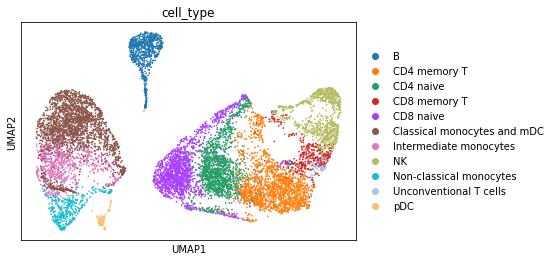

In [12]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')